Imports:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

#digits from sci-kit learn
from sklearn import datasets

Loading datasets. Digits requires some additional pre-processing

In [4]:
#parkinsons dataset
parkinsons = pd.read_csv('../datasets/parkinsons.csv')
parkinsons.rename(columns={'Diagnosis': 'class'}, inplace=True)

#titanic dataset
titanic = pd.read_csv('../datasets/titanic.csv')

#digits from sci-kit learn
def load_digits():
    dig = datasets.load_digits(return_X_y=True)

    X_df = pd.DataFrame(dig[0])
    y_df = pd.DataFrame(dig[1], columns=['class'])
    
    dig = pd.concat([X_df, y_df], axis=1)
    return dig

digits = load_digits()

Globals are used as hyper-parameters in very specific places. Each dataset/example test should reset these

In [5]:
FINAL_MODEL = False
def reset_hyperparameters():
    global LAMBDA, ALPHA
    LAMBDA = 0
    ALPHA = 1
    
reset_hyperparameters()

Preparing data
- cross-validation with stratified sampling
- normalization of data
- one-hot encoding of classes

In [6]:
def normalize_training_data(dataset):
    """
    Normalizes non-class columns to the [0,1] range
    returns non-class columns
    """
    for j in range(dataset.shape[1]):
        max = np.max(dataset[:,j])
        min = np.min(dataset[:,j])
        
        if (min - max != 0):
            dataset[:,j] = (dataset[:,j] - min)/(max-min)
        else:
            dataset[:,j] = 0
    
    return dataset

def vectorize_classes(class_labels):
    """
    one-hot encoding of class labels
    - returns: list of vectors representing y
    """
    classes = np.unique(class_labels)
    classes = np.sort(classes)
    
    #first index is index of second class in codified data
    num_classes = len(classes)
    index_col = np.arange(0, num_classes)
    classes = np.c_[index_col, classes]
    
    y = []
    
    for i in range(class_labels.shape[0]):
        curr_class = class_labels[i]
        class_index = np.where(classes[:, 1] == curr_class)[0][0]
        
        # one hot encoding
        
        #reshapes into vector
        y_i = np.zeros((num_classes), dtype=np.int64)
        
        y_i[class_index] = 1
        y.append(y_i)
    
    #converts to n by num_classes matrix
    y = np.vstack(y)

    return y

def create_folds(x, y, num_folds):
    """
    creates arrays of sub datasets used for cross-validation
    - x and y have to be treated differently
    """
    x_folds = []
    y_folds = []
    
    #roughly the number of observations per class
    fold_size = x.shape[0] / num_folds
    
    #folds have correct distribution of classes
    for i in range(num_folds):
        #prevents uneven distribution of fold-sizes
        lower = i * fold_size
        if (i < num_folds - 1):
            upper = (i + 1) * fold_size
        else:
            upper = x.shape[0]
        
        x_fold = x[int(lower):int(upper)]
        y_fold = y[int(lower):int(upper)]
        
        x_folds.append(x_fold)
        y_folds.append(y_fold)
        
    return x_folds, y_folds
    
def prepare_data(dataset, num_folds):
    #shuffling data - this is the only time we do so
    dataset = dataset.sample(frac=1)
    
    #separates class_labels
    class_labels = dataset.pop('class')
    
    #converts to numpy matrix
    x = dataset.to_numpy()
    class_labels = class_labels.to_numpy()
    
    #normalizes x data to [0,1] range
    #this prevents overflow errors and helps processing
    x = normalize_training_data(x)
    
    #encodes classes into vectors (one hot encoding)
    y = vectorize_classes(class_labels)
    
    #creates an array of sub-datasets used later for cross-validation
    x_folds, y_folds = create_folds(x, y, num_folds)

    return x_folds, y_folds
    
def create_sets(x, y, curr_fold):
    """
    Returns train and test sets for cross-validation
    - Converts x data frames into numpy matrix
    """
    x = copy.deepcopy(x)
    y = copy.deepcopy(y)
    
    #test data, we pop one fold
    test_x = x.pop(curr_fold)
    
    test_y = y.pop(curr_fold)
    
    #train data
    train_x = np.vstack(x)
    train_y = np.vstack(y)
    
    return train_x, train_y, test_x, test_y

In [7]:
def initialize_weights(dimensions, gradient:bool):
    """
    Initializes weights
    """
    matrices = []
    for i in range(len(dimensions) - 1):

        if gradient:
            weights = np.zeros((dimensions[i+1], dimensions[i]+1))
        else:
            #samples initial theta matrices from a standard normal distribution
            weights = np.random.randn(dimensions[i+1], dimensions[i]+1)
            
        matrices.append(weights)
    return matrices

def forward_propagation(instance, weights_list):
    """
    Forward propagates a training instance 
        returns final layer of network
                and all layers of neural network
    """
    activated_layers = []
    
    #activates input layer
    # act_layer = sigmoid(instance)
    act_layer = np.array(instance)
    
    #reshapes into a vector
    act_layer = act_layer.reshape(-1,1)
    
    #adds a bias term
    act_layer = np.insert(act_layer, 0, values=1)
    
    #reshapes again after insertion
    act_layer = act_layer.reshape(-1,1)
    
    #appends
    activated_layers.append(act_layer)
    
    for weights in weights_list:
        layer = np.dot(weights, act_layer)
        
        #sigmoid function layer
        act_layer = sigmoid(layer)
        
        #adding bias for next phase
        act_layer = np.insert(act_layer, 0, values=1)   
        
        #reshapes after insertion
        act_layer = act_layer.reshape(-1,1)
        
        #store the activated layer for back-propagation
        activated_layers.append(act_layer)
        

    y_hat = act_layer[1:]
    activated_layers[len(activated_layers)-1] = activated_layers[len(activated_layers)-1][1:]
    
    return y_hat, activated_layers

def sigmoid(vector):
    return 1 / (1 + np.exp(-vector))

def compute_cost(y_hat, y_true):
    #dimensions must match
    cost_arr = - y_true * np.log(y_hat) - (1-y_true) * np.log(1-y_hat)
    #common overflow error
    return np.sum(cost_arr)

def regularize_cost(weights_list, batch_size):
    """
    Adds cost for overfitting
        Computes squared sum of all non-bias weights
    """
    sum = 0
    for weights in weights_list:
        weights = weights[:, 1:]
        weights = np.square(weights)
        sum += np.sum(weights)
    
    sum = LAMBDA * sum / (2 * batch_size) 
    return sum

def compute_delta(weights_list, activation_layers, y_true):
    """
    Computes delta vectors for each hidden layer
    """
    #we remove from the end and exclude the first layer
    #we also pop to exclude the final pred. layer
    
    #delta of prediction layer
    delta_next = activation_layers.pop() 
    delta_next = delta_next - y_true.reshape(-1,1)
    
    #stores deltas in the same order as activation layers
    deltas = [delta_next]
    
    while len(activation_layers) > 1:
        thetas = weights_list.pop()
        activation = activation_layers.pop()
        activation_2 = 1 - activation
        
        delta_curr = np.dot(np.transpose(thetas), delta_next)
        delta_curr = delta_curr * activation * activation_2
        
        #removes delta associated with bias node
        delta_curr = delta_curr[1:]
        
        #reshapes into a vector
        # delta_curr = delta_curr.reshape(-1,1)
        
        #stores and resets next delta layer
        deltas.insert(0,delta_curr)
        delta_next = delta_curr
        
    return deltas

def compute_gradients(activation_layers, deltas, previous_gradients):
    """
    - computes gradients based on activations of neurons and next layer deltas
    - adds these to the previous gradients
    """
    #deltas list starts at first hidden layer (second layer), 
    for i in range(len(activation_layers) - 1):
        activation = np.transpose(activation_layers[i])
        delta_t = deltas[i]
        
        gradient_layer = np.dot(delta_t, activation)

        #accumulates to previous gradients
        previous_gradients[i] += gradient_layer
        
    return previous_gradients

def regularize_gradients(weights_list, prev_gradients, batch_size):
    """
    Computes a regularized gradient which punishes large weights
    - adds it to the previous gradient and normalizes it for final updates
    """
    # regularization if any
    reg_gradients = []
    for weights in weights_list:
        reg_gradient = LAMBDA * copy.deepcopy(weights)
        reg_gradient[:,0] = 0
        reg_gradients.append(reg_gradient)
    
    for i in range(len(prev_gradients)):
        reg_gradients[i] += prev_gradients[i]
        
    for i in range(len(reg_gradients)):
        reg_gradients[i] = reg_gradients[i] / batch_size
    
    return reg_gradients

def update_weights(weights_list, reg_gradients):
    """
    Updates weights based on regularized gradients
    """
    for i in range(len(weights_list)):
        weights_list[i] = weights_list[i] - ALPHA * reg_gradients[i]
    
    return weights_list

def record_confusion(output):
    """
    Compiles accuracy, recall, precision, and f1 score based on output
    """
    acc = 0
    prec = 0
    rec = 0
    num_classes = output.shape[0]
    n = np.sum(output[:,1])
    
    #for each class compute performance metrics
    for c in range(num_classes):
        tp, tn, fp, fn = 0,0,0,0
        
        pred_pos = output[c,1]
        act_pos = output[c,2]
        
        pred_neg = np.sum(output[:,1]) - pred_pos
        act_neg = np.sum(output[:,2]) - act_pos
        
        tp = pred_pos if pred_pos <= act_pos else act_pos
        tn = pred_neg if pred_neg <= act_neg else act_neg
        fn = act_pos - tp
        fp = act_neg - tn
        
        acc += (tp + tn) / n
        
        #precision causes errors: division by zero
        if tp + fp == 0:
            prec += 0
        elif tp != 0:
            prec += tp / (tp + fp)
        else:
            prec += 0
            
        #found out later that recall also causes errors
        rec += tp / (tp + fn) if tp != 0 else 0
    
    acc = acc / num_classes
    prec = prec / num_classes
    rec = rec / num_classes
    
    f1 = 2 * prec * rec / (prec + rec) if prec + rec != 0 else 0
    
    ret = {
        'accuracy':acc,
        'precision':prec,
        'recall':rec,
        'f1-score':f1
    } 
    return ret
    
def neural_network(dataset, architecture, num_folds, batch_size, num_iterations):
    """
    Runs a neural network based on a dataset, architecture
    - Cross validation is used for training with num_folds
    """
    x,y = prepare_data(dataset, num_folds)
    metrics_sum = []

    for curr_fold in range(num_folds):
        train_x, train_y, test_x, test_y = create_sets(
            x, y, curr_fold)
        
        weights_list = initialize_weights(architecture, gradient=False)
        empty_gradient = initialize_weights(architecture, gradient=True)
        
        gradients = copy.deepcopy(empty_gradient)
        
        cost_list = np.array([])
        cost = 0
        
        instances_seen = 0
        
        #only for the final model
        if FINAL_MODEL:
            test_costs = []
        
        #stopping criteria:
            #loops num_iterations times over the dataset
        for _ in range(num_iterations):
            
            #loops over every iteration of dataset, updates weights when i is a multiple of batch_size
            for i in range(train_x.shape[0]): 
                x_i = train_x[i].reshape(-1,1)
                y_i = train_y[i].reshape(-1,1)
                
                #forward propagation
                y_hat, activation_layers = forward_propagation(x_i, weights_list)
                
                #adds cost for this training instance
                cost += compute_cost(y_hat, y_i)

                #backward pass
                deltas = compute_delta(weights_list.copy(), activation_layers.copy(), y_i)
                
                gradients = compute_gradients(activation_layers, deltas, gradients)
                
                #updates for the following conditional
                instances_seen += 1
                
                #updates weights based on regularized gradients
                if (instances_seen % batch_size) == 0:
                    #regularizes cost and records:
                    cost = cost / batch_size
                    cost += regularize_cost(weights_list, batch_size)
                    cost_list = np.append(cost_list, cost)
                    #resets cost
                    cost = 0
                    
                    #regularizes gradients
                    reg_gradients = regularize_gradients(weights_list, gradients, batch_size)
                    gradients = copy.deepcopy(empty_gradient)
                
                    #updates weights
                    weights_list = update_weights(weights_list, reg_gradients)
                    
                    #observes and records cost for test data - same as below
                    if FINAL_MODEL:
                        test_cost = 0
                        #first column is class, second is y_hat, third is true
                        output = np.c_[np.arange(0, test_y.shape[1]), np.zeros(test_y.shape[1]), np.zeros(test_y.shape[1])]
                        
                        #forward propagation of test set
                        for i in range(test_x.shape[0]):
                            x_i = test_x[i].reshape(-1,1)
                            y_i = test_y[i].reshape(-1,1)
                            
                            y_hat, activation_layers = forward_propagation(x_i, weights_list)
                            test_cost += compute_cost(y_hat, y_i)
                            
                            y_hat_index = np.argmax(y_hat)
                            y_true_index = np.argmax(y_i)
                            output[y_hat_index, 1] += 1
                            output[y_true_index, 2] += 1 
                            
                        test_cost += regularize_cost(weights_list, test_x.shape[0])
                        test_costs.append(test_cost)
                    
        
        #POST-TRAINING evaluation: 
        test_cost = 0
        
        #first column is class, second is y_hat, third is true
        output = np.c_[np.arange(0, test_y.shape[1]), np.zeros(test_y.shape[1]), np.zeros(test_y.shape[1])]
        
        #forward propagation of test set
        for i in range(test_x.shape[0]):
            x_i = test_x[i].reshape(-1,1)
            y_i = test_y[i].reshape(-1,1)
            
            y_hat, activation_layers = forward_propagation(x_i, weights_list)
            test_cost += compute_cost(y_hat, y_i)
            
            y_hat_index = np.argmax(y_hat)
            y_true_index = np.argmax(y_i)
            output[y_hat_index, 1] += 1
            output[y_true_index, 2] += 1 
            
        test_cost += regularize_cost(weights_list, test_x.shape[0])

        #evaluates and records metrics
        scores = record_confusion(output)

        #metrics for one fold
        metrics = {
            'training-costs': cost_list,
            'test-cost-final':test_cost,
            'instances-seen':(instances_seen / num_folds)
        }
        metrics.update(scores)
        
        if FINAL_MODEL:
            temp = {
                'test-costs': test_costs
            }
            metrics.update(temp)
            
        metrics_sum.append(metrics)
        
    #compiles metrics and model hyperparameters
    test = metrics_sum[0]
    stats = {
        'accuracy': [m['accuracy'] for m in metrics_sum],
        'precision': [m['precision'] for m in metrics_sum],
        'recall': [m['recall'] for m in metrics_sum],
        'f1-score': [m['f1-score'] for m in metrics_sum],
        'training-costs': [m['training-costs'] for m in metrics_sum],
        'test-cost-final': [m['test-cost-final'] for m in metrics_sum],
        'instances-seen': np.min([m['instances-seen'] for m in metrics_sum]),
        'batch-size':batch_size,
        'num-iterations': num_iterations,
        'alpha': ALPHA,
        'lambda': LAMBDA,
        'architecture': architecture
    }
    if FINAL_MODEL:
        temp = {
            'test-costs': [m['test-costs'] for m in metrics_sum]
        }
        stats.update(temp)

    return stats

Creates graphs/records for analysis

In [8]:
def plot_test_cost(stats, batch_size, title):
    fig, ax = plt.subplots()
    costs = stats['test-costs']
    
    num_obs = stats['instances-seen']
    
    for i in range(len(costs)):
        costs[i] = np.array(costs[i])
        costs[i].resize(int(num_obs), refcheck=False)
    
    
    costs = np.stack(costs, axis=0)
    y = np.mean(costs, axis=0)

    # mean_costs = np.mean(costs, axis=0)
    
    x = np.arange(0, int(num_obs))
    
    plt.plot(x,y, color='orange')
    
    plt.xlabel('Number of training iterations')
    plt.ylabel('(Regularized) Training Cost')
    
    p_title = 'Training Cost for ' + title
    plt.title(p_title)
    
    file_name = '../figures/' + title + '-test-cost.png'
    plt.savefig(file_name)
    
    plt.show()
    return

def vis_convergence_tune(stats, num_obs=-1, title=''):
    """
    Helps visualize the cost function
    """
    if num_obs == -1:
        num_obs = stats['instances-seen']
    
    costs = stats['training-costs']
    
    for i in range(len(costs)):
        costs[i] = np.array(costs[i])
        costs[i].resize(int(num_obs), refcheck=False)
    
    # costs = stats['training-costs']
    
    costs = np.stack(costs, axis=0)
    y = np.mean(costs, axis=0)
    x = np.arange(0, y.shape[0])
    
    fig, ax = plt.subplots()
    
    plt.title(f'Training Cost per Training Iterations Seen - {title} Dataset')
    plt.xlabel('Number of Training Instances Seen')
    plt.ylabel('Cost')
    

    plt.tight_layout()
    ax.plot(x,y)
    
    plt.savefig(f'../figures/{title}_train_cost.png')
    
    plt.show()
    
def compress_metrics(stats, log=False):
    acc = np.mean(stats['accuracy'])
    rec = np.mean(stats['recall'])
    prec = np.mean(stats['precision'])
    f1 = np.mean(stats['f1-score'])
    
    mean_test_cost = np.mean(stats['test-cost-final'])
    
    if log:
        print(f'accuracy: {acc:.4f}')
        print(f'recall: {rec:.4f}')
        print(f'precision: {prec:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print(f'mean final test cost: {mean_test_cost:.4f}')
    
    ret = {
        'm_accuracy':acc,
        'm_recall':rec,
        'm_precision':prec,
        'm_f1-score':f1,
        'm_test-cost-final':mean_test_cost
    }
    stats.update(ret)
    return

def summarize_to_latex(model_data):    
    data = {}
    
    for i, m in zip(range(len(model_data)), model_data):
        one = round(m['alpha'], 3)
        two = round(m['lambda'], 4)
        three = m['architecture']
        four = round(m['m_accuracy'], 4)
        five = round(m['m_f1-score'], 4)
        six = round(m['m_test-cost-final'],2)
        seven = 0
        
        data[f'Model {i+1}'] = [one, two, three, four, five, six, seven]
    
    #seven columns
    metrics = ['Learning Rate $\\alpha$', 'Regularization $\\lambda$', 'Architecture', 'Mean Accuracy',
               'Mean F1-score', 'Mean Test Cost', 'Converges Around']
    
    df = pd.DataFrame(data, index=metrics)

    latex_table = df.to_latex(float_format="%.4f")

    print(latex_table)

For each dataset, I visually confirm that the training cost flatlines
- I train each model individually and by hand to try and achieve the highest results, recording what I've done

accuracy: 0.9960
recall: 0.9793
precision: 0.9805
F1-Score: 0.9799
mean final test cost: 59.3678


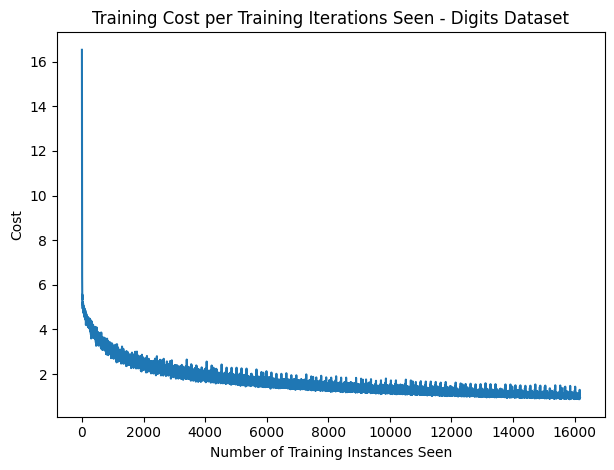

\begin{tabular}{ll}
\toprule
 & Model 1 \\
\midrule
Learning Rate $\alpha$ & 0.0500 \\
Regularization $\lambda$ & 0.0100 \\
Architecture & [64, 32, 32, 10] \\
Mean Accuracy & 0.9960 \\
Mean F1-score & 0.9799 \\
Mean Test Cost & 59.3700 \\
Converges Around & 0 \\
\bottomrule
\end{tabular}



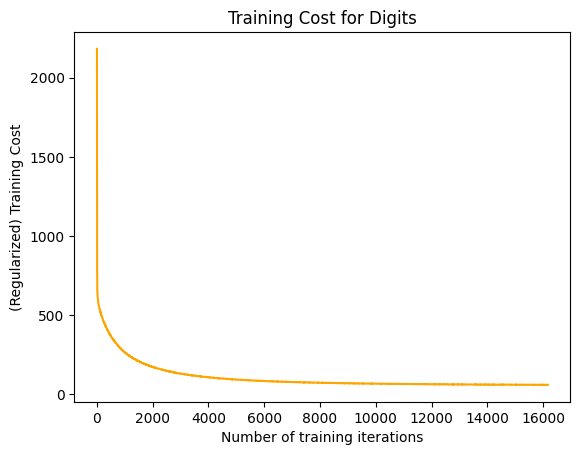

In [14]:
# def run_digits():
    
ALPHA = 0.05
LAMBDA = 0.01
FINAL_MODEL = True
model = neural_network(digits, architecture=[64, 32, 32, 10], num_folds=10, batch_size=10, num_iterations=100)

compress_metrics(model, log=True)
vis_convergence_tune(model, -1, title='Digits')

summarize_to_latex(model_data=[model])

plot_test_cost(model, batch_size=10, title='Digits')
# run_digits()